## Deepmalya Dutta | MDS202218

In [1]:
# ! pip install mlflow

### 1. Importing the libraries

In [2]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix, accuracy_score, precision_recall_curve, auc
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import mlflow
from urllib.parse import urlparse
import numpy as np

### 2. Loading the datasets

In [3]:
train = pd.read_csv("./Datasets/train.csv")
train_X, train_y = train.text, train.spam

test = pd.read_csv("./Datasets/test.csv")
test_X, test_y = test.text, test.spam

val = pd.read_csv("./Datasets/validation.csv")
val_X, val_y = val.text, val.spam

### 3. Fitting a model

In [4]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=2000)),
    ('clf', LogisticRegression(random_state=1, max_iter=2000)),
])

pipeline.fit(train_X, train_y)

train_score = pipeline.score(train_X, train_y)
validation_score = pipeline.score(val_X, val_y)

print(f'Training Accuracy: {train_score}')
print(f'Validation Accuracy: {validation_score}')

Training Accuracy: 0.9901773533424284
Validation Accuracy: 0.9781897491821155


#### Model Predictions

In [5]:
predict = pd.concat([pd.DataFrame(pipeline.predict(test_X)), pd.DataFrame(test_y.values)], axis=1)
predict.columns = ["Predicted values", "Actual values"]
predict.head(10)

,Predicted values,Actual values
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
5,1,1
6,0,1
7,0,0
8,0,0
9,0,0


### 4. Improving the model

In [6]:
def eval_metrics(actual_y, pred_y):
    precision, recall, _ = precision_recall_curve(actual_y, pred_y)
    return auc(recall, precision)

- Model 1 - Logistic Regression

In [7]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression(random_state=1, max_iter=2000)),
])

space = dict()
space['tfidf__max_features'] = [1000, 2000, 5000]
space['clf__C'] = [0.01, 0.1, 1.0]

search = GridSearchCV(pipeline, space, cv=3, verbose=1, n_jobs=-1, scoring='accuracy')
result = search.fit(pd.concat([train_X, val_X], axis=0), pd.concat([train_y, val_y], axis=0))

print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


Best Score: 0.9777405479724471
Best Hyperparameters: {'clf__C': 1.0, 'tfidf__max_features': 2000}


In [8]:
mlflow.sklearn.autolog()

clf = search.best_estimator_
y_pred = clf.predict(test_X)
aucpr = eval_metrics(test_y, y_pred)
acc = accuracy_score(test_y, y_pred)
conf = confusion_matrix(test_y, y_pred)

with mlflow.start_run(run_name=f"tfidf__max_features : {2000}, clf__C : {1.0}"):
  
    mlflow.log_param("tfidf__max_features", 2000)
    mlflow.log_param("clf__C", 1.0)
    mlflow.log_metric("accuracy", acc)
    mlflow.log_metric("AUCPR",aucpr)
    mlflow.log_dict(np.array(conf).tolist(), "confusion_matrix.json")
    mlflow.sklearn.log_model(clf, "model")

    print("\nRandom Classifier Model (tfidf__max_features={:f}, clf__C={:f}):".format(2000, 1.0))
    print(f"Accuracy: {acc}")
    print(f"AUCPR: {aucpr} ")
    print(f"Confusion Matrix:\n {conf} \n \n")

    tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme
    mlflow.sklearn.log_model(
        sk_model=clf,
        artifact_path="sklearn-model",
        registered_model_name="logistic-regression-classification-model"
    )
    if tracking_url_type_store != "file":
      mlflow.sklearn.log_model(clf, "model", registered_model_name="LogisticRegression")
    else:
      mlflow.sklearn.log_model(clf, "model")



Random Classifier Model (tfidf__max_features=2000.000000, clf__C=1.000000):
Accuracy: 0.9842931937172775
AUCPR: 0.9734449231626915 
Confusion Matrix:
 [[874   2]
 [ 16 254]] 
 



Registered model 'logistic-regression-classification-model' already exists. Creating a new version of this model...
Created version '2' of model 'logistic-regression-classification-model'.


In [9]:
mlflow.tracking.MlflowClient().get_model_version("logistic-regression-classification-model", "2")

<ModelVersion: aliases=[], creation_timestamp=1708239830405, current_stage='None', description=None, last_updated_timestamp=1708239830405, name='logistic-regression-classification-model', run_id='4d6841577994458fbebca4ce23705299', run_link=None, source='file:///Users/deepmalya/Library/Mobile%20Documents/com~apple~CloudDocs/CMI/Assignments/Sem%204/AML/Assignment%202/mlruns/0/4d6841577994458fbebca4ce23705299/artifacts/sklearn-model', status='READY', status_message=None, tags={}, user_id=None, version=2>

In [10]:
# ! mlflow ui

- Model 2 - Random Forest

In [11]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('rf', RandomForestClassifier(random_state=1, n_estimators=100)),
])

space = dict()
space['tfidf__max_features'] = [1000, 2000, 5000]
space['rf__n_estimators'] = [50, 100, 200]

search = GridSearchCV(pipeline, space, cv=3, verbose=1, n_jobs=-1, scoring='accuracy')
result = search.fit(pd.concat([train_X, val_X], axis=0), pd.concat([train_y, val_y], axis=0))

print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

2024/02/18 12:34:08 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '1fd8aa2143de48449f3056d75b0285e0', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


2024/02/18 12:34:08 WARNING mlflow.sklearn: Unrecognized dataset type <class 'pandas.core.series.Series'>. Dataset logging skipped.


Fitting 3 folds for each of 9 candidates, totalling 27 fits


2024/02/18 12:34:31 INFO mlflow.sklearn.utils: Logging the 5 best runs, 4 runs will be omitted.


Best Score: 0.9851589366961878
Best Hyperparameters: {'rf__n_estimators': 200, 'tfidf__max_features': 5000}


In [12]:
mlflow.sklearn.autolog()

rf = search.best_estimator_
y_pred = rf.predict(test_X)
aucpr = eval_metrics(test_y, y_pred)
acc = accuracy_score(test_y, y_pred)
conf = confusion_matrix(test_y, y_pred)

with mlflow.start_run(run_name=f"tfidf__max_features : {5000}, rf__n_estimators : {200}"):
  
    mlflow.log_param("tfidf__max_features", 5000)
    mlflow.log_param("rf__n_estimators", 200)
    mlflow.log_metric("accuracy", acc)
    mlflow.log_metric("AUCPR",aucpr)
    mlflow.log_dict(np.array(conf).tolist(), "confusion_matrix.json")
    mlflow.sklearn.log_model(rf, "model")

    print("\nRandom Classifier Model (tfidf__max_features={:f}, rf__n_estimators={:f}):".format(5000, 200))
    print(f"Accuracy: {acc}")
    print(f"AUCPR: {aucpr} ")
    print(f"Confusion Matrix:\n {conf} \n \n")

    tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme
    mlflow.sklearn.log_model(
        sk_model=rf,
        artifact_path="sklearn-model",
        registered_model_name="random-forest-classification-model"
    )
    if tracking_url_type_store != "file":
      mlflow.sklearn.log_model(rf, "model", registered_model_name="RandomForestClassifier")
    else:
      mlflow.sklearn.log_model(rf, "model")



Random Classifier Model (tfidf__max_features=5000.000000, rf__n_estimators=200.000000):
Accuracy: 0.9869109947643979
AUCPR: 0.9747404234315229 
Confusion Matrix:
 [[866  10]
 [  5 265]] 
 



Registered model 'random-forest-classification-model' already exists. Creating a new version of this model...
Created version '3' of model 'random-forest-classification-model'.


In [13]:
mlflow.tracking.MlflowClient().get_model_version("random-forest-classification-model", "3")

<ModelVersion: aliases=[], creation_timestamp=1708239896163, current_stage='None', description=None, last_updated_timestamp=1708239896163, name='random-forest-classification-model', run_id='93d9120547854466ab05c7a5fbbdc4d1', run_link=None, source='file:///Users/deepmalya/Library/Mobile%20Documents/com~apple~CloudDocs/CMI/Assignments/Sem%204/AML/Assignment%202/mlruns/0/93d9120547854466ab05c7a5fbbdc4d1/artifacts/sklearn-model', status='READY', status_message=None, tags={}, user_id=None, version=3>

- Model 3 - Decision Tree

In [14]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('dt', DecisionTreeClassifier(random_state=1)),
])

space = dict()
space['tfidf__max_features'] = [1000, 2000, 5000]
space['dt__max_depth'] = [None, 10, 20, 30]

search = GridSearchCV(pipeline, space, cv=3, verbose=1, n_jobs=-1, scoring='accuracy')
result = search.fit(pd.concat([train_X, val_X], axis=0), pd.concat([train_y, val_y], axis=0))

print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

2024/02/18 12:35:02 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '949ec399c5774ed398cedc6d41deb1eb', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2024/02/18 12:35:02 WARNING mlflow.sklearn: Unrecognized dataset type <class 'pandas.core.series.Series'>. Dataset logging skipped.


Fitting 3 folds for each of 12 candidates, totalling 36 fits


2024/02/18 12:35:15 INFO mlflow.sklearn.utils: Logging the 5 best runs, 7 runs will be omitted.


Best Score: 0.9591875045001491
Best Hyperparameters: {'dt__max_depth': 30, 'tfidf__max_features': 1000}


In [15]:
mlflow.sklearn.autolog()

dt = search.best_estimator_
y_pred = dt.predict(test_X)
aucpr = eval_metrics(test_y, y_pred)
acc = accuracy_score(test_y, y_pred)
conf = confusion_matrix(test_y, y_pred)

with mlflow.start_run(run_name=f"tfidf__max_features : {1000}, dt__max_depth : {30}"):
  
    mlflow.log_param("tfidf__max_features", 1000)
    mlflow.log_param("dt__max_depth", 30)
    mlflow.log_metric("accuracy", acc)
    mlflow.log_metric("AUCPR",aucpr)
    mlflow.log_dict(np.array(conf).tolist(), "confusion_matrix.json")
    mlflow.sklearn.log_model(dt, "model")

    print("\nRandom Classifier Model (tfidf__max_features={:f}, dt__max_depth={:f}):".format(1000, 30))
    print(f"Accuracy: {acc}")
    print(f"AUCPR: {aucpr} ")
    print(f"Confusion Matrix:\n {conf} \n \n")

    tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme
    mlflow.sklearn.log_model(
        sk_model=dt,
        artifact_path="sklearn-model",
        registered_model_name="decision-tree-classification-model"
    )
    if tracking_url_type_store != "file":
      mlflow.sklearn.log_model(dt, "model", registered_model_name="DecisionTreeClassifier")
    else:
      mlflow.sklearn.log_model(dt, "model")



Random Classifier Model (tfidf__max_features=1000.000000, dt__max_depth=30.000000):
Accuracy: 0.9589877835951134
AUCPR: 0.9232864174146808 
Confusion Matrix:
 [[841  35]
 [ 12 258]] 
 



Registered model 'decision-tree-classification-model' already exists. Creating a new version of this model...
Created version '3' of model 'decision-tree-classification-model'.


In [16]:
mlflow.tracking.MlflowClient().get_model_version("decision-tree-classification-model", "3")

<ModelVersion: aliases=[], creation_timestamp=1708239928408, current_stage='None', description=None, last_updated_timestamp=1708239928408, name='decision-tree-classification-model', run_id='64ad0aa8cc714ca299b155ff2b407b66', run_link=None, source='file:///Users/deepmalya/Library/Mobile%20Documents/com~apple~CloudDocs/CMI/Assignments/Sem%204/AML/Assignment%202/mlruns/0/64ad0aa8cc714ca299b155ff2b407b66/artifacts/sklearn-model', status='READY', status_message=None, tags={}, user_id=None, version=3>

### We see random forest model scores highest accuracy and aupcr on our testing data

In [17]:
pred_y = rf.predict(test_X)
print(classification_report(pred_y, test_y))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       871
           1       0.98      0.96      0.97       275

    accuracy                           0.99      1146
   macro avg       0.99      0.98      0.98      1146
weighted avg       0.99      0.99      0.99      1146



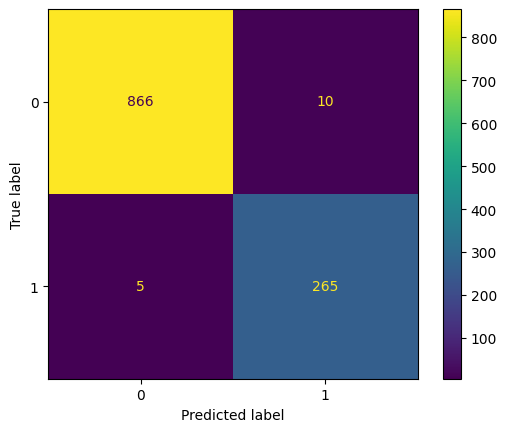

In [18]:
ConfusionMatrixDisplay.from_estimator(rf, test_X, test_y)
plt.show()